# Computing Price and Promo elasticities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px

# Create the dataset

The dataset should have values for each day for at least 2 years. The promotions generally run during the months of Feb, March and then Nov, Dec. The promotions are generally offered as a percent of the price off. For example, 15% off the price of $3.99

## Class and methods for generating the dataframe

In [2]:
class Generate_Dataset:

    """
    Class for generating and visualizing dataset
    Takes the following arguments to initialize

    Parameters
    -------------
    start_date : datetime
        start date for the dataset
    end_date : datetime
        end date of the dataset
    stores : dict
        A dictionary containing the store names as keys and their unit sold intercepts as values
    """

    def __init__(self, start_date:str, end_date:str, stores:dict = None) -> None:
        self.start_date = start_date
        self.end_date = end_date
        self.store_weights = stores
        self.date_array = pd.date_range(start=start_date, end=end_date, freq='D')
        

    def generate_df(self, wt_price:float, wt_promo:float):
        """
        Function to generate the dataframe

        Parameters
        -------------
        start_date : datetime
            start date for the dataset
        end_date : datetime
            end date of the dataset
        stores : dict
            A dictionary containing the store names as keys and their unit sold intercepts as values

        Values
        -------------
        returns a dataframe with the columns date, price, promo_amount, units_sold.
        """

        ## Price
        price = np.where(self.date_array.month<=6, 3, 6) * np.random.normal(loc = 1, scale = 0.05, size = self.date_array.shape[0])

        # Promo indicator and promo
        promo_indicator = np.isin(self.date_array.month, [2,3,11,12])
        promo_amount = np.where(self.date_array.month <=6, 0.2*price, 0.3*price)

        ## Total units sold
        #np.zeros(shape = self.date_array.shape, dtype=np.float32)
        total_units_sold = 2 + (wt_price * np.power(price, 2)) + wt_promo * np.log(1+promo_amount) * promo_indicator
        total_units_sold = np.max(np.array([total_units_sold, np.zeros(shape = self.date_array.shape)]), axis = 0)  ## Make sure that the untis sold is never negative

        pdf_ = pd.DataFrame({"date":self.date_array,
                            "price":price,
                            "promo_amount":promo_amount * promo_indicator,
                            "units_sold":total_units_sold})

        self.data = pdf_

        return self.data

    def viz_ts_data(self):
        """
        Visualizes the generated data
        """
        df_melted = self.data.melt(id_vars="date")

        fig = px.line(data_frame=df_melted, x = 'date', y = 'value', color='variable')
        fig.show()  


In [3]:
SALES = Generate_Dataset(start_date="2021-01-01", end_date="2021-12-31")

In [4]:
weights = {"wt_price":-0.008, "wt_promo":0.3}
df_sales = SALES.generate_df(**weights)

In [5]:
df_sales.head()

,date,price,promo_amount,units_sold
0,2021-01-01,2.870897,0.0,1.934064
1,2021-01-02,3.012092,0.0,1.927418
2,2021-01-03,2.999348,0.0,1.928031
3,2021-01-04,2.865309,0.0,1.934320
4,2021-01-05,3.046123,0.0,1.925769


In [6]:
SALES.viz_ts_data()

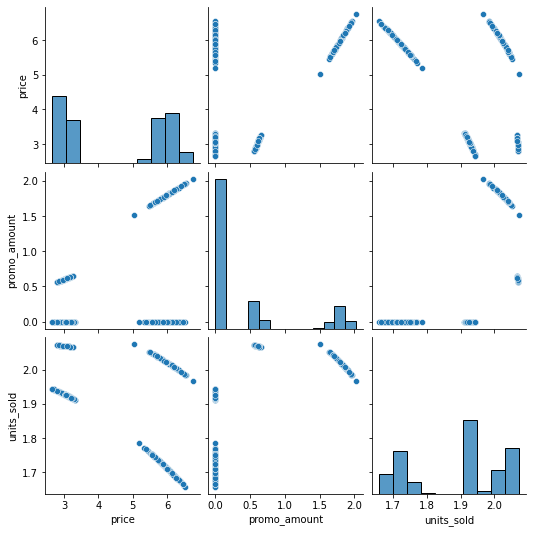

In [7]:
sns.pairplot(data = df_sales)

# Models to estimate the causal effect of promo and prices on units sold

In [8]:
df_sales.dtypes

date            datetime64[ns]
price                  float64
promo_amount           float64
units_sold             float64
dtype: object

In [9]:
def plot_predictions(model, dataset, y = 'units_sold'):
    
    """
    Parameters
    --------------
    model: statemodel
        A model whose predict function would be called on the dataset
    dataset: pd.DataFrame
        A dataset on which the model's predict method would be called
    
    Values
    --------------
    plots a plotly plot for comparing the prediction and the actual
    """

    df_predicted = (dataset
    .assign(predicted = model.predict(dataset))
    .loc[:, ['date', y, 'predicted']]
    .melt(id_vars = 'date')
    )

    fig1 =  px.line(data_frame = df_predicted, x = 'date', y = 'value', color = 'variable')

    fig1.show()

## Simple model

A model without the correct specification of the transformations

In [10]:
model1 = smf.ols("units_sold ~ price + promo_amount", data = df_sales).fit()

In [11]:
print(f"model estimates : \n{model1.params[-2:]}")
print(f"original_estimates = {weights}")

model estimates : 
price          -0.077319
promo_amount    0.177396
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


**Estimates are way off**

In [12]:
plot_predictions(model1, df_sales)

## Model with exact functional form

This should be able to recover the exact estimates. However, in practicality, this cannot be implemented as we would never know the exact form.

In [13]:
df_sales = (df_sales
    .assign(log_one_plus_promo = lambda df: np.log(1+df.promo_amount))
    .assign(squared_price = lambda df: np.power(df.price, 2))
)

In [14]:
model2 = smf.ols("units_sold ~ squared_price + log_one_plus_promo", data = df_sales).fit()

In [15]:
print(f"model estimates : \n{model2.params[-2:]}")
print(f"original_estimates = {weights}")

model estimates : 
squared_price        -0.008
log_one_plus_promo    0.300
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


In [16]:
plot_predictions(model2, df_sales)

**This recovers the correct estimates**

<AxesSubplot:ylabel='Density'>

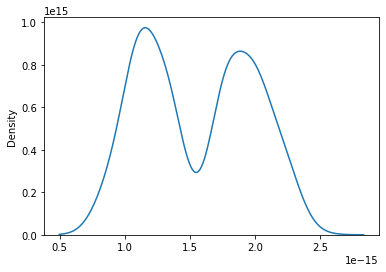

In [17]:
## Residuals analysis
sns.kdeplot(model2.resid)

In [18]:
np.max(model2.resid)

2.4424906541753444e-15

**Residuals seem really bad, but..**

Note that the values are extremely small (in range of 1e-15). Even though the residuals are not normally distributed, they are almost non-existent. So, this should not be concerning.

## Model with interaction between promo_indicator and promo_amount

In [19]:
df_sales = (df_sales
    .assign(promo_ind = lambda df: np.where(df.promo_amount==0, 0, 1))
    .assign(log_promo = lambda df: np.log(df.promo_amount+ 0.00001))
    .assign(log_three_plus_promo = lambda df: np.log(3+df.promo_amount))
    .assign(log_sales_units = lambda df: np.log(df.units_sold))
)
df_sales.head()

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
0,2021-01-01,2.870897,0.0,1.934064,0.0,8.242049,0,-11.512925,1.098612,0.659623
1,2021-01-02,3.012092,0.0,1.927418,0.0,9.072700,0,-11.512925,1.098612,0.656181
2,2021-01-03,2.999348,0.0,1.928031,0.0,8.996088,0,-11.512925,1.098612,0.656499
3,2021-01-04,2.865309,0.0,1.934320,0.0,8.209997,0,-11.512925,1.098612,0.659756
4,2021-01-05,3.046123,0.0,1.925769,0.0,9.278866,0,-11.512925,1.098612,0.655325


In [20]:
model3 = smf.ols("units_sold ~ price + squared_price + log_promo * promo_amount", data = df_sales).fit()

In [21]:
print(f"model estimates : \n{model3.params}")
print(f"original_estimates = {weights}")

model estimates : 
Intercept                 1.982147
price                    -0.000001
squared_price            -0.008000
log_promo                -0.001551
promo_amount              0.225591
log_promo:promo_amount   -0.074101
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


In [22]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             units_sold   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.311e+10
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:34:03   Log-Likelihood:                 3676.1
No. Observations:                 365   AIC:                            -7340.
Df Residuals:                     359   BIC:                            -7317.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.9821   3.68e-05   5.38e+04      0.000       1.982       1.982
price                   -1.42e-06   9.22e-06     -0.154      0.878   -1.95e-05    1.67e-05
squared_price             -0.0080   1.02e-06  -7841.975      0.000      -0.008      -0.008
log_promo                 -0.0016   3.89e-06   -398.215      0.000      -0.002      -0.002
promo_amount               0.2256   5.02e-05   4489.845      0.000       0.225       0.226
log_promo:promo_amount    -0.0741   4.09e-05  -1812.179      0.000      -0.074      -0.074
==============================================================================
Omnibus:                      203.571   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2499.275
Skew:                           2.065   Prob(JB):                         0.00
Kurtosis:                      15.136   Cond. No.                     3.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='log_promo', ylabel='Count'>

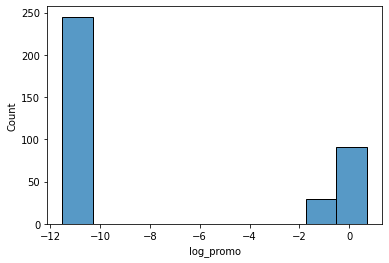

In [23]:
sns.histplot(df_sales, x = "log_promo")

In [24]:
plot_predictions(model3, df_sales, y = 'units_sold')

<AxesSubplot:ylabel='Density'>

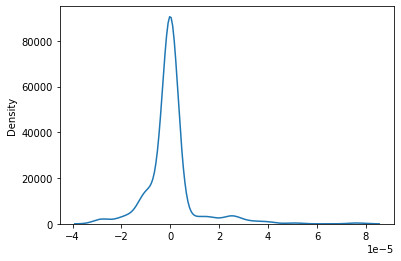

In [25]:
sns.kdeplot(model3.resid)

**Comment :**  
This model also approximates the original functional form almost exactly. The residuals are more normally distributed, but, again are extremely small - suggesting that we are doing a good job. The key take away is, we haven't specified the exact functional form in this model and yet were able to get almost spot-on predictions. The challenge here is to see how good our coefficients from non-linearities are as an approximation to the original functional form.

## Test changes in promo prices

In [26]:
df_sales.iloc[30:40, :]

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
30,2021-01-31,3.319009,0.000000,1.911873,0.000000,11.015823,0,-11.512925,1.098612,0.648084
31,2021-02-01,2.793020,0.558604,2.070729,0.443791,7.800962,1,-0.582296,1.269368,0.727901
32,2021-02-02,2.864404,0.572881,2.070234,0.452909,8.204808,1,-0.557060,1.273372,0.727662
33,2021-02-03,2.891262,0.578252,2.070020,0.456318,8.359398,1,-0.547727,1.274875,0.727558
34,2021-02-04,3.104775,0.620955,2.067788,0.483015,9.639628,1,-0.476481,1.286738,0.726479
35,2021-02-05,2.941552,0.588310,2.069579,0.462671,8.652726,1,-0.530484,1.277681,0.727345
36,2021-02-06,3.223067,0.644613,2.066146,0.497505,10.388161,1,-0.439089,1.293250,0.725685
37,2021-02-07,3.125698,0.625140,2.067518,0.485594,9.769989,1,-0.469764,1.287893,0.726349
38,2021-02-08,3.188356,0.637671,2.066658,0.493275,10.165614,1,-0.449917,1.291344,0.725933
39,2021-02-09,3.159231,0.631846,2.067068,0.489712,9.980743,1,-0.459093,1.289741,0.726131


In [27]:
0.64/3.22

0.19875776397515527

In [28]:
def gen_simulated_df(price:float, model, feature_gen:bool = True):
    
    df_simulated = pd.DataFrame({"price":price,
                            "promo_amount": np.concatenate([np.repeat(0.0, 33), np.repeat(0.2*price, 33), np.repeat(0.3*price, 33)])})

    # df_simulated = pd.DataFrame({"price": price,
    #                             "promo_amount":np.linspace(0, 0.3, 100)})

    df_simulated = df_simulated.assign(promo_ind = lambda df: np.where(df.promo_amount==0, 0, 1))

    if feature_gen:
        df_simulated = (df_simulated
            .assign(log_promo = lambda df: np.log(df.promo_amount+0.00001))
            .assign(squared_price = lambda df: np.power(df.price, 2))
            .assign(log_one_plus_promo = lambda df: np.log(1 + df.promo_amount))
        )

    wt_price = -0.008
    wt_promo = 0.3


    df_simulated = (df_simulated
    .assign(predicted_units = model.predict(df_simulated))
    .assign(actual_units = lambda df: 2 + (wt_price * np.power(df.price, 2)) + wt_promo * np.log(1+df.promo_amount))
    )

    return df_simulated

In [29]:
df_simPrice3 = gen_simulated_df(price = 3.0, model = model3)
df_simPrice6 = gen_simulated_df(price = 6.0, model = model3)

df_sim = pd.concat([df_simPrice3, df_simPrice6], axis = 0)
df_sim2 = df_sim.loc[:, ['price', 'promo_amount', 'predicted_units','actual_units']].melt(id_vars = ['price', 'promo_amount'])

In [30]:
px.line(data_frame = df_sim2, x = 'promo_amount', y = 'value', line_dash = 'variable', color = 'price')#, facet_row = 'price')

# Using a complex tree based model for this prediction

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
df_sales.head()

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
0,2021-01-01,2.870897,0.0,1.934064,0.0,8.242049,0,-11.512925,1.098612,0.659623
1,2021-01-02,3.012092,0.0,1.927418,0.0,9.072700,0,-11.512925,1.098612,0.656181
2,2021-01-03,2.999348,0.0,1.928031,0.0,8.996088,0,-11.512925,1.098612,0.656499
3,2021-01-04,2.865309,0.0,1.934320,0.0,8.209997,0,-11.512925,1.098612,0.659756
4,2021-01-05,3.046123,0.0,1.925769,0.0,9.278866,0,-11.512925,1.098612,0.655325


In [72]:
X = df_sales.loc[:, ['price','promo_amount', 'promo_ind']]#, 'log_promo', 'squared_price', 'log_one_plus_promo']]
y = df_sales.units_sold

In [73]:
model4 = GradientBoostingRegressor().fit(X, y)

In [74]:
df_model4_sim3 = gen_simulated_df(price = 3.0, model = model4, feature_gen = False)
df_model4_sim6 = gen_simulated_df(price = 6.0, model = model4, feature_gen = False)

In [75]:
df_sim4 = pd.concat([df_model4_sim3, df_model4_sim6], axis = 0)
df_sim42 = df_sim4.loc[:, ['price', 'promo_amount', 'predicted_units','actual_units']].melt(id_vars = ['price', 'promo_amount'])

In [76]:
px.line(data_frame = df_sim42, x = 'promo_amount', y = 'value', line_dash = 'variable', color = 'price')#, facet_row = 'price')

In [78]:
df_predicted0 = (df_sales
    .assign(predicted = model4.predict(df_sales.loc[:,  ['price','promo_amount', 'promo_ind',]]))# 'log_promo', 'squared_price', 'log_one_plus_promo']]))
    .loc[:, ['date', 'units_sold', 'predicted']]
)

# pred_df = df_sales

fig1 =  px.line(data_frame = df_predicted0.melt(id_vars = 'date'), x = 'date', y = 'value', color = 'variable')

fig1.show()

<AxesSubplot:xlabel='residuals', ylabel='Density'>

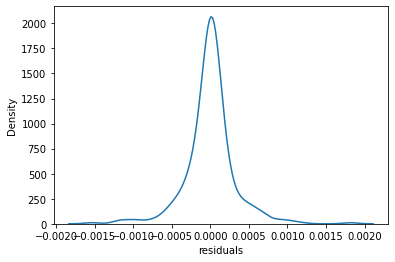

In [79]:
sns.kdeplot(x='residuals', data = df_predicted0.assign(residuals = lambda df: df.units_sold - df.predicted))

In [80]:
model4.feature_importances_

array([0.41820256, 0.36773306, 0.21406438])